In [5]:
# DIVAnd Parameter Validation Notebook
# This notebook performs cross-validation tests to determine optimal parameters for DIVAnd

using CSV, DataFrames, DIVAnd, Statistics, Plots, Interpolations
using Random

In [6]:
bathy_file = "../data/test_transect_bathy.csv"
hydro_file = "../data/test_hydrography.csv"
variable = "Temperature"
vertical_res = 1 # m
horizontal_res = 100 # m

100

In [7]:
# PHASE 1: LOAD AND PREPROCESS
# 1. Load the data files
bathy_df = CSV.read(bathy_file, DataFrame);
hydro_df = CSV.read(hydro_file, DataFrame);

# Convert distances to meters if needed (assuming input is in km)
if maximum(bathy_df.Distance) < 1000
    bathy_df.Distance = bathy_df.Distance * 1000;
    hydro_df.Distance = hydro_df.Distance * 1000;
end

# 2. Calculate typical distance between stations
all_obs_x = hydro_df.Distance;
station_distances = [];
unique_stations = unique(all_obs_x);
sort!(unique_stations);
for i in 2:lastindex(unique_stations)
    push!(station_distances, unique_stations[i] - unique_stations[i-1])
end
typical_station_spacing = median(station_distances);

# 3. Create interpolation grid
distance_extent = maximum(hydro_df.Distance) - minimum(hydro_df.Distance);
depth_extent = maximum(bathy_df.BottomDepth);

n_horizontal = Int(ceil(distance_extent / horizontal_res));
n_vertical = Int(ceil(depth_extent / vertical_res));

x_regular = range(minimum(hydro_df.Distance), maximum(hydro_df.Distance), length=n_horizontal);
y_regular = range(0, depth_extent, length=n_vertical);

# 4. Prepare grid coordinates
X_grid = [x for x in x_regular, y in y_regular];
Y_grid = [y for x in x_regular, y in y_regular];
xi = (X_grid, Y_grid);

# 5. Create mask based on bathymetry
mask = trues(length(x_regular), length(y_regular));
for (i, x) in enumerate(x_regular)
    bathy_depth = LinearInterpolation(bathy_df.Distance, 
                                    bathy_df.BottomDepth, 
                                    extrapolation_bc=Flat())(x);
    for (j, y) in enumerate(y_regular)
        if y > bathy_depth
            mask[i, j] = false;
        end
    end
end

# 6. Set up scale factors
pm = ones(length(x_regular), length(y_regular)) / horizontal_res;
pn = ones(length(x_regular), length(y_regular)) / vertical_res;
pmn = (pm, pn);


In [40]:
# Phase 1: Coarse grid search
function cv_correlation_lengths_coarse(folds=5)
    # Create folds
    n = length(obs_temp)
    indices = Random.shuffle(1:n)
    fold_size = div(n, folds)
    
    # Setup parameter ranges
    station_distances = []
    unique_stations = unique(obs_x)
    sort!(unique_stations)
    for i in 2:length(unique_stations)
        push!(station_distances, unique_stations[i] - unique_stations[i-1])
    end
    typical_station_spacing = median(station_distances)
    
    # COARSE grid: 10×10 = 100 points instead of 40×40 = 1600
    len_x_factors = collect(range(1.0, 3.5, length=10))
    len_y_factors = collect(range(0.0025, 0.50, length=10))
    
    domain_y = depth_extent
    
    results = DataFrame(
        len_x_factor = Float64[],
        len_y_factor = Float64[], 
        len_x = Float64[],
        len_y = Float64[],
        rmse = Float64[],
        mae = Float64[],
        bias = Float64[]
    )
    
    epsilon2_value = 0.05
    best_rmse = Inf
    
    # Run coarse grid search
    for x_factor in len_x_factors
        for y_factor in len_y_factors
            len_x_val = typical_station_spacing * x_factor
            len_y_val = domain_y * y_factor
            
            fold_rmses = []
            fold_maes = []
            fold_biases = []
            
            for fold in 1:folds
                start_idx = (fold - 1) * fold_size + 1
                end_idx = fold == folds ? n : fold * fold_size
                
                test_idx = indices[start_idx:end_idx]
                train_idx = setdiff(indices, test_idx)
                
                rmse, mae, bias = perform_interpolation(
                    train_idx, test_idx, len_x_val, len_y_val, epsilon2_value
                )
                
                push!(fold_rmses, rmse)
                push!(fold_maes, mae)
                push!(fold_biases, bias)
            end
            
            avg_rmse = mean(fold_rmses)
            avg_mae = mean(fold_maes)
            avg_bias = mean(fold_biases)
            
            push!(results, (x_factor, y_factor, len_x_val, len_y_val, avg_rmse, avg_mae, avg_bias))
            
            if avg_rmse < best_rmse
                best_rmse = avg_rmse
                println("COARSE GRID - NEW BEST: len_x = $(len_x_val)m, len_y = $(len_y_val)m, RMSE = $(avg_rmse)")
            end
        end
    end
    
    return results
end

# Phase 2: Fine grid search on promising regions
function cv_correlation_lengths_fine(coarse_results, num_top_regions=3, folds=5)
    # Extract best regions from coarse search
    sort!(coarse_results, :rmse)
    top_regions = coarse_results[1:min(num_top_regions, nrow(coarse_results)), :]
    
    # Setup for fine search
    n = length(obs_temp)
    indices = Random.shuffle(1:n)
    fold_size = div(n, folds)
    
    station_distances = []
    unique_stations = unique(obs_x)
    sort!(unique_stations)
    for i in 2:length(unique_stations)
        push!(station_distances, unique_stations[i] - unique_stations[i-1])
    end
    typical_station_spacing = median(station_distances)
    domain_y = depth_extent
    
    results = DataFrame(
        len_x_factor = Float64[],
        len_y_factor = Float64[], 
        len_x = Float64[],
        len_y = Float64[],
        rmse = Float64[],
        mae = Float64[],
        bias = Float64[]
    )
    
    epsilon2_value = 0.05
    best_rmse = minimum(coarse_results.rmse)
    
    # For each promising region, do a fine search
    for region in eachrow(top_regions)
        # Create fine grid (5×5) around this region
        x_min = max(1.0, region.len_x_factor - 0.2)
        x_max = min(3.5, region.len_x_factor + 0.2)
        y_min = max(0.0025, region.len_y_factor - 0.05)
        y_max = min(0.5, region.len_y_factor + 0.05)
        
        len_x_factors = collect(range(x_min, x_max, length=5))
        len_y_factors = collect(range(y_min, y_max, length=5))
        
        println("Refining search around len_x_factor = $(region.len_x_factor), len_y_factor = $(region.len_y_factor)")
        
        # Fine grid search in this region
        for x_factor in len_x_factors
            for y_factor in len_y_factors
                len_x_val = typical_station_spacing * x_factor
                len_y_val = domain_y * y_factor
                
                fold_rmses = []
                fold_maes = []
                fold_biases = []
                
                for fold in 1:folds
                    start_idx = (fold - 1) * fold_size + 1
                    end_idx = fold == folds ? n : fold * fold_size
                    
                    test_idx = indices[start_idx:end_idx]
                    train_idx = setdiff(indices, test_idx)
                    
                    rmse, mae, bias = perform_interpolation(
                        train_idx, test_idx, len_x_val, len_y_val, epsilon2_value
                    )
                    
                    push!(fold_rmses, rmse)
                    push!(fold_maes, mae)
                    push!(fold_biases, bias)
                end
                
                avg_rmse = mean(fold_rmses)
                avg_mae = mean(fold_maes)
                avg_bias = mean(fold_biases)
                
                push!(results, (x_factor, y_factor, len_x_val, len_y_val, avg_rmse, avg_mae, avg_bias))
                
                if avg_rmse < best_rmse
                    best_rmse = avg_rmse
                    println("FINE GRID - NEW BEST: len_x = $(len_x_val)m, len_y = $(len_y_val)m, RMSE = $(avg_rmse)")
                end
            end
        end
    end
    
    return results
end

cv_correlation_lengths_fine (generic function with 3 methods)

In [41]:
# Use the two-phase approach
println("Phase 1: Coarse grid search...")
coarse_results = cv_correlation_lengths_coarse()

println("\nPhase 2: Fine grid search around promising regions...")
fine_results = cv_correlation_lengths_fine(coarse_results)

# Combine and find best overall
all_results = vcat(coarse_results, fine_results)
sort!(all_results, :rmse)
best_params = first(all_results)
println("\nBest parameters: len_x = $(best_params.len_x)m, len_y = $(best_params.len_y)m, RMSE = $(best_params.rmse)")

Phase 1: Coarse grid search...
COARSE GRID - NEW BEST: len_x = 40299.389795210765m, len_y = 3.4518206054957807m, RMSE = 0.7654249011610905
COARSE GRID - NEW BEST: len_x = 85076.48956766717m, len_y = 3.4518206054957807m, RMSE = 0.764377403947674
COARSE GRID - NEW BEST: len_x = 96270.76451078127m, len_y = 3.4518206054957807m, RMSE = 0.7618028012555615
COARSE GRID - NEW BEST: len_x = 107465.03945389537m, len_y = 3.4518206054957807m, RMSE = 0.7590337680341547
COARSE GRID - NEW BEST: len_x = 118659.31439700948m, len_y = 3.4518206054957807m, RMSE = 0.7563844418309031
COARSE GRID - NEW BEST: len_x = 129853.58934012358m, len_y = 3.4518206054957807m, RMSE = 0.7541271100886904
COARSE GRID - NEW BEST: len_x = 141047.86428323766m, len_y = 3.4518206054957807m, RMSE = 0.7524814142558051

Phase 2: Fine grid search around promising regions...
Refining search around len_x_factor = 3.5, len_y_factor = 0.0025
FINE GRID - NEW BEST: len_x = 139032.89479347714m, len_y = 3.4518206054957807m, RMSE = 0.7523607

In [42]:
function optimize_diva_parameters(mask, pmn, xi, x_obs, obs_values, typical_station_spacing, depth_extent)
    # STRATEGY 1: Create a coarser grid for parameter optimization
    downsample = 4  # Downsample factor
    mask_coarse = mask[1:downsample:end, 1:downsample:end]
    pm_coarse = pmn[1][1:downsample:end, 1:downsample:end]
    pn_coarse = pmn[2][1:downsample:end, 1:downsample:end]
    pmn_coarse = (pm_coarse, pn_coarse)
    
    # Downsample coordinate grid
    X_coarse = xi[1][1:downsample:end, 1:downsample:end]
    Y_coarse = xi[2][1:downsample:end, 1:downsample:end]
    xi_coarse = (X_coarse, Y_coarse)
    
    # STRATEGY 2: Two-phase approach for parameter search
    
    # Initial guesses for correlation lengths
    len_x_initial = typical_station_spacing * 2.0
    len_y_initial = depth_extent * 0.05
    len_y_initial = max(len_y_initial, 5.0) # At least 5m vertically
    len = (len_x_initial, len_y_initial)
    
    # Initial guess for epsilon2
    epsilon2_initial = 0.1
    
    println("Phase 1: Coarse parameter search...")
    
    # STRATEGY 3: Reduced test points for first phase
    bestfactorl_coarse, bestfactore_coarse, _ = DIVAnd_cv(
        mask_coarse, pmn_coarse, xi_coarse, x_obs, obs_values, 
        len, epsilon2_initial, 5, 5, 0,  # Fewer test points
        MEMTOFIT=4  # STRATEGY 4: Memory management
    )
    
    # Calculate refined starting points for phase 2
    len_refined = (len[1] * bestfactorl_coarse, len[2] * bestfactorl_coarse)
    epsilon2_refined = epsilon2_initial * bestfactore_coarse
    
    println("Phase 2: Refined parameter search...")
    
    # Second phase with more focused search
    bestfactorl_fine, bestfactore_fine, cvval = DIVAnd_cv(
        mask_coarse, pmn_coarse, xi_coarse, x_obs, obs_values, 
        len_refined, epsilon2_refined, 7, 7, 0,  # More test points for refinement
        MEMTOFIT=4
    )
    
    # Calculate final best parameters
    best_len_x = len_refined[1] * bestfactorl_fine
    best_len_y = len_refined[2] * bestfactorl_fine
    best_epsilon2 = epsilon2_refined * bestfactore_fine
    
    println("Optimization complete!")
    println("Best parameters: len_x = $best_len_x, len_y = $best_len_y, epsilon2 = $best_epsilon2")
    
    return (len_x=best_len_x, len_y=best_len_y, epsilon2=best_epsilon2, cvval=cvval)
end

optimize_diva_parameters (generic function with 1 method)

In [43]:
# Usage:
# Calculate background field
background_temp = mean(obs_temp)
obs_anomaly = obs_temp .- background_temp

# Optimize parameters
optimized_params = optimize_diva_parameters(
    mask, pmn, xi, x_obs, obs_anomaly, typical_station_spacing, depth_extent
)

# Use optimized parameters for final interpolation (full resolution)
len_opt = (optimized_params.len_x, optimized_params.len_y)
temp_field_anom, s = DIVAndrun(mask, pmn, xi, x_obs, obs_anomaly, 
                               len_opt, optimized_params.epsilon2)

# Add background back for final field
temp_field = temp_field_anom .+ background_temp

Phase 1: Coarse parameter search...
Phase 2: Refined parameter search...
Optimization complete!
Best parameters: len_x = 10624.988431449578, len_y = 9.10077154696534, epsilon2 = 0.0031004774099477896


2001×1381 Matrix{Float64}:
 14.4059  14.4648  14.4841  14.484   14.4775  …   12.1742   12.1742   12.1742
 14.3923  14.4504  14.4711  14.4679  14.4593     NaN       NaN       NaN
 14.3854  14.443   14.4642  14.4598  14.4501     NaN       NaN       NaN
 14.3785  14.4356  14.4568  14.4515  14.441      NaN       NaN       NaN
 14.3716  14.4281  14.4491  14.4432  14.4318     NaN       NaN       NaN
 14.3646  14.4204  14.4412  14.4348  14.4227  …  NaN       NaN       NaN
 14.3577  14.4127  14.433   14.4263  14.4136     NaN       NaN       NaN
 14.3507  14.4049  14.4247  14.4178  14.4045     NaN       NaN       NaN
 14.3436  14.397   14.4162  14.4091  14.3955     NaN       NaN       NaN
 14.3366  14.389   14.4075  14.4004  14.3866     NaN       NaN       NaN
  ⋮                                           ⋱                        ⋮
 15.475   15.5869  15.7793  15.5224  14.9768     NaN       NaN       NaN
 15.4847  15.5998  15.8018  15.5434  14.9867     NaN       NaN       NaN
 15.4944  15.6133  

In [8]:
# 2. Helper functions for cross-validation
function perform_interpolation(train_idx, test_idx, len_x, len_y, epsilon2_value)
    # Training data
    train_x = obs_x[train_idx]
    train_y = obs_y[train_idx]
    train_temp = obs_temp[train_idx]
    
    # Calculate background field from training data
    background = mean(train_temp)
    train_anomaly = train_temp .- background
    
    # Set up grid (simplified version)
    x_range = range(minimum(obs_x), maximum(obs_x), length=100)
    y_range = range(0, maximum(bathy_df.BottomDepth), length=100)
    
    X_g = [x for x in x_range, y in y_range]
    Y_g = [y for x in x_range, y in y_range]
    
    # Scale factors
    pm = ones(length(x_range), length(y_range)) / (maximum(x_range) - minimum(x_range)) * length(x_range)
    pn = ones(length(x_range), length(y_range)) / (maximum(y_range) - minimum(y_range)) * length(y_range)
    
    # Create bathymetry mask
    mask = trues(length(x_range), length(y_range))
    for i in 1:length(x_range)
        bathy_depth = LinearInterpolation(bathy_df.Distance, bathy_df.BottomDepth, extrapolation_bc=Flat())(x_range[i])
        for j in 1:length(y_range)
            if y_range[j] > bathy_depth
                mask[i, j] = false
            end
        end
    end
    
    # Perform interpolation
    x_obs = (train_x, train_y)
    xi = (X_g, Y_g)
    pmn = (pm, pn)
    len = (len_x, len_y)
    
    # Run DIVAnd
    field_anomaly, s = DIVAndrun(mask, pmn, xi, x_obs, train_anomaly, len, epsilon2_value)
    field = field_anomaly .+ background
    
    # Extract predictions at test points
    predictions = []
    for i in 1:length(test_idx)
        test_x = obs_x[test_idx[i]]
        test_y = obs_y[test_idx[i]]
        
        # Find nearest grid point
        x_idx = argmin(abs.(x_range .- test_x))
        y_idx = argmin(abs.(y_range .- test_y))
        
        if mask[x_idx, y_idx]
            push!(predictions, field[x_idx, y_idx])
        else
            push!(predictions, NaN)
        end
    end
    
    # Calculate error metrics
    actual = obs_temp[test_idx]
    valid_idx = .!isnan.(predictions)
    
    if sum(valid_idx) > 0
        rmse = sqrt(mean((predictions[valid_idx] .- actual[valid_idx]).^2))
        mae = mean(abs.(predictions[valid_idx] .- actual[valid_idx]))
        bias = mean(predictions[valid_idx] .- actual[valid_idx])
        return rmse, mae, bias
    else
        return Inf, Inf, Inf
    end
end

# 3. Perform k-fold cross-validation for correlation length
function cv_correlation_lengths(folds=5)
    # Create folds
    n = length(obs_temp)
    indices = Random.shuffle(1:n)
    fold_size = div(n, folds)
    
    # Parameter ranges to test
    station_distances = []
    unique_stations = unique(obs_x)
    sort!(unique_stations)
    for i in 2:length(unique_stations)
        push!(station_distances, unique_stations[i] - unique_stations[i-1])
    end
    typical_station_spacing = median(station_distances)
    
    # Create parameter ranges to test
    # len_x_factors = [1.0, 1.25, 1.5, 2.0, 2.5, 3.0, 3.5]
    len_x_factors = collect(range(1.0, 3.5, length=10))
    # len_y_factors = [0.005, 0.01, 0.015, 0.02, 0.025]
    len_y_factors = collect(range(0.005, 0.50, length=10))
    
    # domain_y = maximum(obs_y) - minimum(obs_y)
    domain_y = depth_extent
    
    # Storage for results
    results = DataFrame(
        len_x_factor = Float64[],
        len_y_factor = Float64[], 
        len_x = Float64[],
        len_y = Float64[],
        rmse = Float64[],
        mae = Float64[],
        bias = Float64[]
    )
    
    # Fixed epsilon2
    epsilon2_value = 0.05

    # Track best RMSE so far
    best_rmse = Inf
    
    # Cross-validation
    for x_factor in len_x_factors
        for y_factor in len_y_factors
            len_x_val = typical_station_spacing * x_factor
            len_y_val = domain_y * y_factor
            
            fold_rmses = []
            fold_maes = []
            fold_biases = []
            
            for fold in 1:folds
                start_idx = (fold - 1) * fold_size + 1
                end_idx = fold == folds ? n : fold * fold_size
                
                test_idx = indices[start_idx:end_idx]
                train_idx = setdiff(indices, test_idx)
                
                rmse, mae, bias = perform_interpolation(
                    train_idx, test_idx, len_x_val, len_y_val, epsilon2_value
                )
                
                push!(fold_rmses, rmse)
                push!(fold_maes, mae)
                push!(fold_biases, bias)
            end
            
            # Average metrics across folds
            avg_rmse = mean(fold_rmses)
            avg_mae = mean(fold_maes)
            avg_bias = mean(fold_biases)
            
            push!(results, (x_factor, y_factor, len_x_val, len_y_val, avg_rmse, avg_mae, avg_bias))

            # Print only if we've found a better RMSE
            if avg_rmse < best_rmse
                best_rmse = avg_rmse
                println("NEW BEST: len_x = $(len_x_val)m, len_y = $(len_y_val)m, RMSE = $(avg_rmse)")
            end
        end
    end
    
    return results
end

# 4. Perform epsilon2 validation
function cv_epsilon2(best_len_x, best_len_y, folds=5)
    # Create folds
    n = length(obs_temp)
    indices = Random.shuffle(1:n)
    fold_size = div(n, folds)
    
    # Parameter range
    # epsilon2_values = [0.01, 0.05, 0.1, 0.2, 0.5, 1.0]
    epsilon2_values = union([1e-5, 1e-4], collect(range(1e-4 + 1e-4, 5e-1, step=1e-3)))
    
    # Storage for results
    results = DataFrame(
        epsilon2 = Float64[],
        rmse = Float64[],
        mae = Float64[],
        bias = Float64[]
    )
    
    # Cross-validation
    for eps2 in epsilon2_values
        fold_rmses = []
        fold_maes = []
        fold_biases = []
        
        for fold in 1:folds
            start_idx = (fold - 1) * fold_size + 1
            end_idx = fold == folds ? n : fold * fold_size
            
            test_idx = indices[start_idx:end_idx]
            train_idx = setdiff(indices, test_idx)
            
            rmse, mae, bias = perform_interpolation(
                train_idx, test_idx, best_len_x, best_len_y, eps2
            )
            
            push!(fold_rmses, rmse)
            push!(fold_maes, mae)
            push!(fold_biases, bias)
        end
        
        # Average metrics across folds
        avg_rmse = mean(fold_rmses)
        avg_mae = mean(fold_maes)
        avg_bias = mean(fold_biases)
        
        push!(results, (eps2, avg_rmse, avg_mae, avg_bias))
        println("Tested: epsilon2 = $(eps2), RMSE = $(avg_rmse)")
    end
    
    return results
end

cv_epsilon2 (generic function with 2 methods)

In [9]:
# Clean data - remove missing values
valid_data = dropmissing(hydro_df, :Temperature)
obs_temp = valid_data.Temperature
obs_x = valid_data.Distance
obs_y = valid_data.Depth

# 5. Run the correlation length validation
println("Starting correlation length cross-validation...")
len_results = cv_correlation_lengths()

# 6. Find optimal correlation lengths
sort!(len_results, :rmse)
best_params = first(len_results)
println("Best parameters: len_x_factor = $(best_params.len_x_factor), len_y_factor = $(best_params.len_y_factor)")
println("Best correlation lengths: len_x = $(best_params.len_x)m, len_y = $(best_params.len_y)m")
println("Error metrics: RMSE = $(best_params.rmse), MAE = $(best_params.mae), Bias = $(best_params.bias)")

Starting correlation length cross-validation...
NEW BEST: len_x = 40299.389795210765m, len_y = 6.9036412109915615m, RMSE = 0.7647325151977802
NEW BEST: len_x = 118659.31439700948m, len_y = 6.9036412109915615m, RMSE = 0.7634019382472129
NEW BEST: len_x = 129853.58934012358m, len_y = 6.9036412109915615m, RMSE = 0.7610956965166796
NEW BEST: len_x = 141047.86428323766m, len_y = 6.9036412109915615m, RMSE = 0.758803094777585
Best parameters: len_x_factor = 3.5, len_y_factor = 0.005
Best correlation lengths: len_x = 141047.86428323766m, len_y = 6.9036412109915615m
Error metrics: RMSE = 0.758803094777585, MAE = 0.4684091193844644, Bias = 0.06770198502745366


In [17]:
extrema(len_results.len_x)

(40299.389795210765, 141047.86428323766)

In [10]:
println("Best parameters: len_x_factor = $(best_params.len_x_factor), len_y_factor = $(best_params.len_y_factor)")
println("Best correlation lengths: len_x = $(best_params.len_x)m, len_y = $(best_params.len_y)m")
println("Error metrics: RMSE = $(best_params.rmse), MAE = $(best_params.mae), Bias = $(best_params.bias)")

Best parameters: len_x_factor = 3.5, len_y_factor = 0.005
Best correlation lengths: len_x = 141047.86428323766m, len_y = 6.9036412109915615m
Error metrics: RMSE = 0.758803094777585, MAE = 0.4684091193844644, Bias = 0.06770198502745366


In [11]:
# 7. Run epsilon2 validation with best correlation lengths
println("\nStarting epsilon2 cross-validation...")
eps2_results = cv_epsilon2(best_params.len_x, best_params.len_y)

# 8. Find optimal epsilon2
sort!(eps2_results, :rmse)
best_eps2 = first(eps2_results)
println("Best epsilon2: $(best_eps2.epsilon2)")
println("Error metrics: RMSE = $(best_eps2.rmse), MAE = $(best_eps2.mae), Bias = $(best_eps2.bias)")


Starting epsilon2 cross-validation...
Tested: epsilon2 = 1.0e-5, RMSE = 0.7818839485099333
Tested: epsilon2 = 0.0001, RMSE = 0.7817852932284615
Tested: epsilon2 = 0.0002, RMSE = 0.7816763603190756
Tested: epsilon2 = 0.0012, RMSE = 0.7806240244123229
Tested: epsilon2 = 0.0022, RMSE = 0.7796316800085835
Tested: epsilon2 = 0.0032, RMSE = 0.7786907726614103
Tested: epsilon2 = 0.0042, RMSE = 0.7777945816297507
Tested: epsilon2 = 0.0052, RMSE = 0.7769377458976305
Tested: epsilon2 = 0.0062, RMSE = 0.7761159294358816
Tested: epsilon2 = 0.0072, RMSE = 0.7753255802979924
Tested: epsilon2 = 0.0082, RMSE = 0.7745637543476941
Tested: epsilon2 = 0.0092, RMSE = 0.7738279843609959
Tested: epsilon2 = 0.0102, RMSE = 0.7731161815220241
Tested: epsilon2 = 0.0112, RMSE = 0.7724265603945554
Tested: epsilon2 = 0.0122, RMSE = 0.7717575811385476
Tested: epsilon2 = 0.0132, RMSE = 0.7711079045498319
Tested: epsilon2 = 0.0142, RMSE = 0.7704763567444683
Tested: epsilon2 = 0.0152, RMSE = 0.7698619011705254
Tested:

In [ ]:
# 7. Run epsilon2 validation with best correlation lengths
println("\nStarting epsilon2 cross-validation...")
eps2_results = cv_epsilon2(best_params.len_x, best_params.len_y)

# 8. Find optimal epsilon2
sort!(eps2_results, :rmse)
best_eps2 = first(eps2_results)
println("Best epsilon2: $(best_eps2.epsilon2)")
println("Error metrics: RMSE = $(best_eps2.rmse), MAE = $(best_eps2.mae), Bias = $(best_eps2.bias)")


Starting epsilon2 cross-validation...
Tested: epsilon2 = 1.0e-5, RMSE = 0.7857795840457206
Tested: epsilon2 = 0.0001, RMSE = 0.7856185113266503
Tested: epsilon2 = 0.0002, RMSE = 0.7854410234034062
Tested: epsilon2 = 0.0003, RMSE = 0.7852650577399369
Tested: epsilon2 = 0.0004, RMSE = 0.785090577249847
Tested: epsilon2 = 0.0005, RMSE = 0.7849175464904171
Tested: epsilon2 = 0.0006, RMSE = 0.7847459315685801
Tested: epsilon2 = 0.0007, RMSE = 0.7845757000532743
Tested: epsilon2 = 0.0008, RMSE = 0.7844068208936521
Tested: epsilon2 = 0.0009, RMSE = 0.7842392643424619
Tested: epsilon2 = 0.001, RMSE = 0.7840730018848497
Tested: epsilon2 = 0.0011, RMSE = 0.7839080061711302
Tested: epsilon2 = 0.0012, RMSE = 0.7837442509545646
Tested: epsilon2 = 0.0013, RMSE = 0.7835817110326043
Tested: epsilon2 = 0.0014, RMSE = 0.7834203621918634
Tested: epsilon2 = 0.0015, RMSE = 0.7832601811568118
Tested: epsilon2 = 0.0016, RMSE = 0.7831011455412485
Tested: epsilon2 = 0.0017, RMSE = 0.7829432338029163
Tested: e

In [20]:
len_y = 55.56387
len_x = 64869.82877
len = (len_x, len_y)

(64869.82877, 55.56387)

In [38]:
typeof(epsilon2)

Float64

In [39]:
valid_data = dropmissing(hydro_df, :Temperature)
obs_x = valid_data.Distance
obs_y = valid_data.Depth
x_obs = (obs_x, obs_y)
obs_temp = valid_data.Temperature
background = mean(obs_temp)
obs_anomaly = obs_temp .- background
epsilon2 = 0.089

cv_results = DIVAnd_cv(mask,pmn,xi,x_obs,obs_anomaly,len,epsilon2,5,5,0)

(0.2035032870924282, 0.3764560540428128, 0.017532499539767123, [0.021672478338335726, 0.020819181823883478, 0.019869764937298466, 0.018960804751958237, 0.018219840270526637, 0.0177708123707479, 0.017777998260707882, 0.01858199173627122, 0.02111075888793258, 0.028086321852054376  …  0.24703965846138906, 0.2851936183206845, 0.33427972645834275, 0.4085784218189329, 0.5257326764157338, 0.700569656649261, 0.9413657827960221, 1.26337815907564, 1.7080838586991784, 2.3191010166883053], [-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [-1.5, -1.2, -0.9, -0.6, -0.3, 0.0, 0.3, 0.6, 0.9, 1.2  …  -1.2, -0.9, -0.6, -0.3, 0.0, 0.3, 0.6, 0.9, 1.2, 1.5], [0.022050556494930335 0.022029116542941384 … 0.04938361531575607 0.049989348132825163; 0.022013899061292214 0.021992832849752387 … 0.04958920177228884 0.050186898631932875; … ; 0.21460890342598238 0.215781858513623 … 2.5293523108679716 2.5453278495277334; 0.21689749157903082 0.2180463459

In [ ]:
# # 1. Load the same data
# bathy_df = CSV.read("../data/test_transect_bathy.csv", DataFrame)
# hydro_df = CSV.read("../data/test_hydrography.csv", DataFrame)

# # Convert distances to meters
# bathy_df.Distance = bathy_df.Distance * 1000
# hydro_df.Distance = hydro_df.Distance * 1000

# # Clean data - remove missing values
# valid_data = dropmissing(hydro_df, :Temperature)
# obs_x = valid_data.Distance
# obs_y = valid_data.Depth
# obs_temp = valid_data.Temperature

# println("Working with $(length(obs_temp)) valid temperature observations")

Working with 2105 valid temperature observations


In [2]:
"""
    prepare_diva_data(bathy_file, hydro_file; kwargs...)

Load and prepare data for DIVAnd processing.

# Returns
- Named tuple with all data structures needed for optimization and interpolation
"""
function prepare_diva_data(
    bathy_file::String,
    hydro_file::String;
    horizontal_res::Real=100,
    vertical_res::Real=1
)
    # 1. Load the data files
    bathy_df = CSV.read(bathy_file, DataFrame);
    hydro_df = CSV.read(hydro_file, DataFrame);
    
    # Convert distances to meters if needed (assuming input is in km)
    if maximum(bathy_df.Distance) < 1000
        bathy_df.Distance = bathy_df.Distance * 1000;
        hydro_df.Distance = hydro_df.Distance * 1000;
    end
    
    # 2. Calculate typical distance between stations
    all_obs_x = hydro_df.Distance;
    station_distances = [];
    unique_stations = unique(all_obs_x);
    sort!(unique_stations);
    for i in 2:lastindex(unique_stations)
        push!(station_distances, unique_stations[i] - unique_stations[i-1])
    end
    typical_station_spacing = median(station_distances);
    
    # 3. Create interpolation grid
    distance_extent = maximum(hydro_df.Distance) - minimum(hydro_df.Distance);
    depth_extent = maximum(bathy_df.BottomDepth);
    
    n_horizontal = Int(ceil(distance_extent / horizontal_res));
    n_vertical = Int(ceil(depth_extent / vertical_res));
    
    x_regular = range(minimum(hydro_df.Distance), maximum(hydro_df.Distance), length=n_horizontal);
    y_regular = range(0, depth_extent, length=n_vertical);
    
    # 4. Prepare grid coordinates
    X_grid = [x for x in x_regular, y in y_regular];
    Y_grid = [y for x in x_regular, y in y_regular];
    xi = (X_grid, Y_grid);
    
    # 5. Create mask based on bathymetry
    mask = trues(length(x_regular), length(y_regular));
    for (i, x) in enumerate(x_regular)
        bathy_depth = LinearInterpolation(bathy_df.Distance, 
                                        bathy_df.BottomDepth, 
                                        extrapolation_bc=Flat())(x);
        for (j, y) in enumerate(y_regular)
            if y > bathy_depth
                mask[i, j] = false;
            end
        end
    end
    
    # 6. Set up scale factors
    pm = ones(length(x_regular), length(y_regular)) / horizontal_res;
    pn = ones(length(x_regular), length(y_regular)) / vertical_res;
    pmn = (pm, pn);
    
    # Return all prepared data structures
    return (
        bathy_df=bathy_df,
        hydro_df=hydro_df,
        typical_station_spacing=typical_station_spacing,
        x_grid=x_regular,
        y_grid=y_regular,
        X_grid=X_grid, 
        Y_grid=Y_grid,
        xi=xi,
        mask=mask,
        pmn=pmn
    );
end


prepare_diva_data

In [ ]:

data_prep = prepare_diva_data(bathy_file, hydro_file);

In [11]:
verbose = true;
# Extract common data
mask = data_prep.mask;
pmn = data_prep.pmn;
xi = data_prep.xi;

# Use shared extraction function - ELIMINATES DUPLICATION
var_data = extract_variable_data(data_prep.hydro_df, variable);
x_obs = var_data.x_obs;
obs_anomaly = var_data.anomaly;

# Initial correlation length estimates
len_x_initial = data_prep.typical_station_spacing * 2.0;
len_y_initial = maximum(data_prep.bathy_df.BottomDepth) * 0.05;
len_y_initial = max(len_y_initial, 5.0);

len = (len_x_initial, len_y_initial);
epsilon2_initial = 0.1;

In [ ]:
# 3. Perform k-fold cross-validation for correlation length
function cv_correlation_lengths(folds=5)
    # Create folds
    n = length(obs_temp)
    indices = Random.shuffle(1:n)
    fold_size = div(n, folds)
    
    # Parameter ranges to test
    station_distances = []
    unique_stations = unique(obs_x)
    sort!(unique_stations)
    for i in 2:length(unique_stations)
        push!(station_distances, unique_stations[i] - unique_stations[i-1])
    end
    typical_station_spacing = median(station_distances)
    
    # Create parameter ranges to test
    # len_x_factors = [1.0, 1.25, 1.5, 2.0, 2.5, 3.0, 3.5]
    len_x_factors = collect(range(1.0, 3.5, length=20))
    # len_y_factors = [0.005, 0.01, 0.015, 0.02, 0.025]
    len_y_factors = collect(range(0.0025, 0.50, length=20))
    
    domain_y = maximum(obs_y) - minimum(obs_y)
    
    # Storage for results
    results = DataFrame(
        len_x_factor = Float64[],
        len_y_factor = Float64[], 
        len_x = Float64[],
        len_y = Float64[],
        rmse = Float64[],
        mae = Float64[],
        bias = Float64[]
    )
    
    # Fixed epsilon2
    epsilon2_value = 0.05
    
    # Cross-validation
    for x_factor in len_x_factors
        for y_factor in len_y_factors
            len_x_val = typical_station_spacing * x_factor
            len_y_val = domain_y * y_factor
            
            fold_rmses = []
            fold_maes = []
            fold_biases = []
            
            for fold in 1:folds
                start_idx = (fold - 1) * fold_size + 1
                end_idx = fold == folds ? n : fold * fold_size
                
                test_idx = indices[start_idx:end_idx]
                train_idx = setdiff(indices, test_idx)
                
                rmse, mae, bias = perform_interpolation(
                    train_idx, test_idx, len_x_val, len_y_val, epsilon2_value
                )
                
                push!(fold_rmses, rmse)
                push!(fold_maes, mae)
                push!(fold_biases, bias)
            end
            
            # Average metrics across folds
            avg_rmse = mean(fold_rmses)
            avg_mae = mean(fold_maes)
            avg_bias = mean(fold_biases)
            
            push!(results, (x_factor, y_factor, len_x_val, len_y_val, avg_rmse, avg_mae, avg_bias))
            println("Tested: len_x = $(len_x_val)m, len_y = $(len_y_val)m, RMSE = $(avg_rmse)")
        end
    end
    
    return results
end

In [15]:
best_params

Row,len_x_factor,len_y_factor,len_x,len_y,rmse,mae,bias
,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,3.5,0.005,1.41048e5,6.90364,0.758803,0.468409,0.067702


In [ ]:
# Phase 1: Quick coarse search
nl_coarse = 3;
ne_coarse = 3;
method = 0;

bestfactorl_coarse, bestfactore_coarse, _ = DIVAnd_cv(
    mask, pmn, xi, x_obs, obs_anomaly, 
    len, epsilon2_initial, nl_coarse, ne_coarse, method
);

In [3]:
# Parameter ranges to test
station_distances = []
unique_stations = unique(obs_x)
sort!(unique_stations)
for i in 2:length(unique_stations)
    push!(station_distances, unique_stations[i] - unique_stations[i-1])
end
typical_station_spacing = median(station_distances)

40299.389795210765

In [6]:
function optimize_parameters()
    # Setup observation points and values
    x_obs = (obs_x, obs_y)
    obs_anomaly = obs_temp .- mean(obs_temp)
    
    # Setup grid
    x_range = range(minimum(obs_x), maximum(obs_x), length=100)
    y_range = range(0, maximum(bathy_df.BottomDepth), length=100)
    
    X_g = [x for x in x_range, y in y_range]
    Y_g = [y for x in x_range, y in y_range]
    xi = (X_g, Y_g)
    
    # Setup mask based on bathymetry
    mask = trues(length(x_range), length(y_range))
    for i in 1:length(x_range)
        bathy_depth = LinearInterpolation(bathy_df.Distance, 
                                          bathy_df.BottomDepth, 
                                          extrapolation_bc=Flat())(x_range[i])
        for j in 1:length(y_range)
            if y_range[j] > bathy_depth
                mask[i, j] = false
            end
        end
    end
    
    # Scale factors
    pm = ones(length(x_range), length(y_range)) / (maximum(x_range) - minimum(x_range)) * length(x_range)
    pn = ones(length(x_range), length(y_range)) / (maximum(y_range) - minimum(y_range)) * length(y_range)
    pmn = (pm, pn)
    
    # Calculate typical station spacing for initial length guess
    station_distances = []
    unique_stations = unique(obs_x)
    sort!(unique_stations)
    for i in 2:length(unique_stations)
        push!(station_distances, unique_stations[i] - unique_stations[i-1])
    end
    typical_station_spacing = median(station_distances)
    
    # Direct initial estimates - no complicated functions
    len_x_initial = typical_station_spacing * 2.0
    len_y_initial = maximum(bathy_df.BottomDepth) * 0.05
    len_y_initial = max(len_y_initial, 5.0) # At least 5m vertically
    
    # Set initial correlation length tuple
    len = (len_x_initial, len_y_initial)
    println("Using initial correlation lengths: len_x=$(len[1])m, len_y=$(len[2])m")
    
    # Initial guess for epsilon2
    epsilon2_initial = 0.1
    
    # Number of test points to try around initial values
    nl = 20   # Test points for correlation length
    ne = 20   # Test points for epsilon2
    method = 0  # Automatic cross-validation method
    
    # Perform cross-validation - let DIVAnd_cv do all the work
    bestfactorl, bestfactore, cvval = DIVAnd_cv(
        mask, pmn, xi, x_obs, obs_anomaly, 
        len, epsilon2_initial, nl, ne, method
    )
    
    # Calculate best parameters by applying multiplication factors
    best_len = (len[1] * bestfactorl, len[2] * bestfactorl)
    best_epsilon2 = epsilon2_initial * bestfactore
    
    return (len=best_len, epsilon2=best_epsilon2, cvval=cvval)
end

optimize_parameters (generic function with 1 method)

In [23]:
# Get cross-validation results
cv_results = optimize_parameters()

# Extract best parameters
best_len_x = cv_results.len[1]
best_len_y = cv_results.len[2]
best_epsilon2 = cv_results.epsilon2

println("Best parameters from DIVAnd_cv:")
println("len_x = $best_len_x")
println("len_y = $best_len_y")
println("epsilon2 = $best_epsilon2")
println("RMSE = $(cv_results.cvval)")

UndefVarError: UndefVarError: `optimize_parameters` not defined

In [1]:
# Use DIVAnd's built-in cross-validation
function optimize_parameters()
    # Setup observation points and values
    x_obs = (obs_x, obs_y)
    obs_anomaly = obs_temp .- mean(obs_temp)
    
    # Setup grid
    x_range = range(minimum(obs_x), maximum(obs_x), length=100)
    y_range = range(0, maximum(bathy_df.BottomDepth), length=100)
    
    X_g = [x for x in x_range, y in y_range]
    Y_g = [y for x in x_range, y in y_range]
    xi = (X_g, Y_g)
    
    # Setup mask based on bathymetry
    mask = trues(length(x_range), length(y_range))
    for i in 1:length(x_range)
        bathy_depth = LinearInterpolation(bathy_df.Distance, 
                                          bathy_df.BottomDepth, 
                                          extrapolation_bc=Flat())(x_range[i])
        for j in 1:length(y_range)
            if y_range[j] > bathy_depth
                mask[i, j] = false
            end
        end
    end
    
    # Scale factors
    pm = ones(length(x_range), length(y_range)) / (maximum(x_range) - minimum(x_range)) * length(x_range)
    pn = ones(length(x_range), length(y_range)) / (maximum(y_range) - minimum(y_range)) * length(y_range)
    pmn = (pm, pn)

    # Get better initial length scale estimates using DIVAnd's built-in functions
    # For 2D transect data, we need a workaround since fithorz/vert assume 3D data
    # Create a pseudo-3D dataset with constant latitude
    fake_lat = zeros(length(obs_x)) # Constant latitude (we're on a transect)
    x_obs_3d = (obs_x, fake_lat, obs_y) # (lon, lat, depth) format expected by fithorzlen
    
    # Get depth levels for vertical scale estimation
    depth_levels = sort(unique(obs_y))
    
    # Use DIVAnd's built-in length scale estimation
    try
        # Try to estimate horizontal correlation length
        len_x_initial, _ = DIVAnd.fithorzlen(
            x_obs_3d, 
            obs_temp, 
            depth_levels,
            smoothz=100,
            limitlen=true,
            maxnsamp=25,  # REDUCED for speed
            minlen=typical_station_spacing * 1.0,
            maxlen=typical_station_spacing * 10.0
        )
        
        # Try to estimate vertical correlation length
        len_y_initial, _ = DIVAnd.fitvertlen(
            x_obs_3d, 
            obs_temp,
            depth_levels,
            minlen=1.0,
            maxlen=maximum(bathy_df.BottomDepth) * 0.5
        )
        
        println("Estimated initial length scales: horizontal=$(len_x_initial)m, vertical=$(len_y_initial)m")
        
    catch e
        # Fall back to heuristic estimates if the estimation fails
        println("Length scale estimation failed: $e")
        println("Using heuristic estimates instead")
        
        # Calculate typical station spacing
        station_distances = []
        unique_stations = unique(obs_x)
        sort!(unique_stations)
        for i in 2:length(unique_stations)
            push!(station_distances, unique_stations[i] - unique_stations[i-1])
        end
        typical_station_spacing = median(station_distances)
        
        # Fallback to heuristic estimates
        len_x_initial = typical_station_spacing * 2.0
        len_y_initial = maximum(bathy_df.BottomDepth) * 0.05
    end
    
    # Ensure we have sensible values (positive and not too small)
    len_x_initial = max(len_x_initial, typical_station_spacing * 0.5)
    len_y_initial = max(len_y_initial, 5.0) # At least 5m vertically
    
    # Set initial correlation length tuple
    len = (len_x_initial, len_y_initial)
    println("Using initial correlation lengths: len_x=$(len[1])m, len_y=$(len[2])m")
    
    # Initial guess for epsilon2
    epsilon2_initial = 0.1
    
    # Number of test points to try around initial values
    nl = 20   # Test points for correlation length
    ne = 20   # Test points for epsilon2
    method = 0  # Automatic cross-validation method
    
    # Perform cross-validation
    bestfactorl, bestfactore, cvval = DIVAnd_cv(
        mask, pmn, xi, x_obs, obs_anomaly, 
        len, epsilon2_initial, nl, ne, method,
        verbose=false
    )
    
    # Calculate best parameters by applying multiplication factors
    best_len = (len[1] * bestfactorl, len[2] * bestfactorl)
    best_epsilon2 = epsilon2_initial * bestfactore
    
    return (len=best_len, epsilon2=best_epsilon2, cvval=cvval)
end

optimize_parameters (generic function with 1 method)

In [ ]:
# Use DIVAnd's built-in cross-validation with better initial length estimates
function optimize_parameters()
    # Setup observation points and values
    x_obs = (obs_x, obs_y)
    obs_anomaly = obs_temp .- mean(obs_temp)
    
    # Setup grid
    x_range = range(minimum(obs_x), maximum(obs_x), length=100)
    y_range = range(0, maximum(bathy_df.BottomDepth), length=100)
    
    X_g = [x for x in x_range, y in y_range]
    Y_g = [y for x in x_range, y in y_range]
    xi = (X_g, Y_g)
    
    # Setup mask based on bathymetry
    mask = trues(length(x_range), length(y_range))
    for i in 1:length(x_range)
        bathy_depth = LinearInterpolation(bathy_df.Distance, 
                                          bathy_df.BottomDepth, 
                                          extrapolation_bc=Flat())(x_range[i])
        for j in 1:length(y_range)
            if y_range[j] > bathy_depth
                mask[i, j] = false
            end
        end
    end
    
    # Scale factors
    pm = ones(length(x_range), length(y_range)) / (maximum(x_range) - minimum(x_range)) * length(x_range)
    pn = ones(length(x_range), length(y_range)) / (maximum(y_range) - minimum(y_range)) * length(y_range)
    pmn = (pm, pn)
    
    # Get better initial length scale estimates using DIVAnd's built-in functions
    # For 2D transect data, we need a workaround since fithorz/vert assume 3D data
    # Create a pseudo-3D dataset with constant latitude
    fake_lat = zeros(length(obs_x)) # Constant latitude (we're on a transect)
    x_obs_3d = (obs_x, fake_lat, obs_y) # (lon, lat, depth) format expected by fithorzlen
    
    # Get depth levels for vertical scale estimation
    depth_levels = sort(unique(obs_y))
    
    # Use DIVAnd's built-in length scale estimation
    try
        # Try to estimate horizontal correlation length
        len_x_initial, _ = DIVAnd.fithorzlen(
            x_obs_3d, 
            obs_temp, 
            depth_levels,
            smoothz=100,
            limitlen=true,
            maxnsamp=25,  # REDUCED for speed
            minlen=typical_station_spacing * 1.0,
            maxlen=typical_station_spacing * 10.0
        )
        
        # Try to estimate vertical correlation length
        len_y_initial, _ = DIVAnd.fitvertlen(
            x_obs_3d, 
            obs_temp,
            depth_levels,
            minlen=1.0,
            maxlen=maximum(bathy_df.BottomDepth) * 0.5
        )
        
        println("Estimated initial length scales: horizontal=$(len_x_initial)m, vertical=$(len_y_initial)m")
        
    catch e
        # Fall back to heuristic estimates if the estimation fails
        println("Length scale estimation failed: $e")
        println("Using heuristic estimates instead")
        
        # Calculate typical station spacing
        station_distances = []
        unique_stations = unique(obs_x)
        sort!(unique_stations)
        for i in 2:length(unique_stations)
            push!(station_distances, unique_stations[i] - unique_stations[i-1])
        end
        typical_station_spacing = median(station_distances)
        
        # Fallback to heuristic estimates
        len_x_initial = typical_station_spacing * 2.0
        len_y_initial = maximum(bathy_df.BottomDepth) * 0.05
    end
    
    # Ensure we have sensible values (positive and not too small)
    len_x_initial = max(len_x_initial, typical_station_spacing * 0.5)
    len_y_initial = max(len_y_initial, 5.0) # At least 5m vertically
    
    # Set initial correlation length tuple
    len = (len_x_initial, len_y_initial)
    println("Using initial correlation lengths: len_x=$(len[1])m, len_y=$(len[2])m")
    
    # Initial guess for epsilon2
    epsilon2_initial = 0.1
    
    # Number of test points to try around initial values
    nl = 20   # Test points for correlation length
    ne = 20   # Test points for epsilon2
    method = 0  # Automatic cross-validation method
    
    # Perform cross-validation
    bestfactorl, bestfactore, cvval = DIVAnd_cv(
        mask, pmn, xi, x_obs, obs_anomaly, 
        len, epsilon2_initial, nl, ne, method
    )
    
    # Calculate best parameters by applying multiplication factors
    best_len = (len[1] * bestfactorl, len[2] * bestfactorl)
    best_epsilon2 = epsilon2_initial * bestfactore
    
    return (len=best_len, epsilon2=best_epsilon2, cvval=cvval)
end

optimize_parameters (generic function with 1 method)

In [2]:
# Get cross-validation results
cv_results = optimize_parameters()

# Extract best parameters
best_len_x = cv_results.len[1]
best_len_y = cv_results.len[2]
best_epsilon2 = cv_results.epsilon2

println("Best parameters from DIVAnd_cv:")
println("len_x = $best_len_x")
println("len_y = $best_len_y")
println("epsilon2 = $best_epsilon2")
println("RMSE = $(cv_results.cvval)")

UndefVarError: UndefVarError: `obs_x` not defined

In [14]:
# 2. Helper functions for cross-validation
function perform_interpolation(train_idx, test_idx, len_x, len_y, epsilon2_value)
    # Training data
    train_x = obs_x[train_idx]
    train_y = obs_y[train_idx]
    train_temp = obs_temp[train_idx]
    
    # Calculate background field from training data
    background = mean(train_temp)
    train_anomaly = train_temp .- background
    
    # Set up grid (simplified version)
    x_range = range(minimum(obs_x), maximum(obs_x), length=100)
    y_range = range(0, maximum(bathy_df.BottomDepth), length=100)
    
    X_g = [x for x in x_range, y in y_range]
    Y_g = [y for x in x_range, y in y_range]
    
    # Scale factors
    pm = ones(length(x_range), length(y_range)) / (maximum(x_range) - minimum(x_range)) * length(x_range)
    pn = ones(length(x_range), length(y_range)) / (maximum(y_range) - minimum(y_range)) * length(y_range)
    
    # Create bathymetry mask
    mask = trues(length(x_range), length(y_range))
    for i in 1:length(x_range)
        bathy_depth = LinearInterpolation(bathy_df.Distance, bathy_df.BottomDepth, extrapolation_bc=Flat())(x_range[i])
        for j in 1:length(y_range)
            if y_range[j] > bathy_depth
                mask[i, j] = false
            end
        end
    end
    
    # Perform interpolation
    x_obs = (train_x, train_y)
    xi = (X_g, Y_g)
    pmn = (pm, pn)
    len = (len_x, len_y)
    
    # Run DIVAnd
    field_anomaly, s = DIVAndrun(mask, pmn, xi, x_obs, train_anomaly, len, epsilon2_value)
    field = field_anomaly .+ background
    
    # Extract predictions at test points
    predictions = []
    for i in 1:length(test_idx)
        test_x = obs_x[test_idx[i]]
        test_y = obs_y[test_idx[i]]
        
        # Find nearest grid point
        x_idx = argmin(abs.(x_range .- test_x))
        y_idx = argmin(abs.(y_range .- test_y))
        
        if mask[x_idx, y_idx]
            push!(predictions, field[x_idx, y_idx])
        else
            push!(predictions, NaN)
        end
    end
    
    # Calculate error metrics
    actual = obs_temp[test_idx]
    valid_idx = .!isnan.(predictions)
    
    if sum(valid_idx) > 0
        rmse = sqrt(mean((predictions[valid_idx] .- actual[valid_idx]).^2))
        mae = mean(abs.(predictions[valid_idx] .- actual[valid_idx]))
        bias = mean(predictions[valid_idx] .- actual[valid_idx])
        return rmse, mae, bias
    else
        return Inf, Inf, Inf
    end
end

# 3. Perform k-fold cross-validation for correlation length
function cv_correlation_lengths(folds=5)
    # Create folds
    n = length(obs_temp)
    indices = Random.shuffle(1:n)
    fold_size = div(n, folds)
    
    # Parameter ranges to test
    station_distances = []
    unique_stations = unique(obs_x)
    sort!(unique_stations)
    for i in 2:length(unique_stations)
        push!(station_distances, unique_stations[i] - unique_stations[i-1])
    end
    typical_station_spacing = median(station_distances)
    
    # Create parameter ranges to test
    # len_x_factors = [1.0, 1.25, 1.5, 2.0, 2.5, 3.0, 3.5]
    len_x_factors = collect(range(1.0, 3.5, length=20))
    # len_y_factors = [0.005, 0.01, 0.015, 0.02, 0.025]
    len_y_factors = collect(range(0.0025, 0.50, length=20))
    
    domain_y = maximum(obs_y) - minimum(obs_y)
    
    # Storage for results
    results = DataFrame(
        len_x_factor = Float64[],
        len_y_factor = Float64[], 
        len_x = Float64[],
        len_y = Float64[],
        rmse = Float64[],
        mae = Float64[],
        bias = Float64[]
    )
    
    # Fixed epsilon2
    epsilon2_value = 0.05
    
    # Cross-validation
    for x_factor in len_x_factors
        for y_factor in len_y_factors
            len_x_val = typical_station_spacing * x_factor
            len_y_val = domain_y * y_factor
            
            fold_rmses = []
            fold_maes = []
            fold_biases = []
            
            for fold in 1:folds
                start_idx = (fold - 1) * fold_size + 1
                end_idx = fold == folds ? n : fold * fold_size
                
                test_idx = indices[start_idx:end_idx]
                train_idx = setdiff(indices, test_idx)
                
                rmse, mae, bias = perform_interpolation(
                    train_idx, test_idx, len_x_val, len_y_val, epsilon2_value
                )
                
                push!(fold_rmses, rmse)
                push!(fold_maes, mae)
                push!(fold_biases, bias)
            end
            
            # Average metrics across folds
            avg_rmse = mean(fold_rmses)
            avg_mae = mean(fold_maes)
            avg_bias = mean(fold_biases)
            
            push!(results, (x_factor, y_factor, len_x_val, len_y_val, avg_rmse, avg_mae, avg_bias))
            println("Tested: len_x = $(len_x_val)m, len_y = $(len_y_val)m, RMSE = $(avg_rmse)")
        end
    end
    
    return results
end

# 4. Perform epsilon2 validation
function cv_epsilon2(best_len_x, best_len_y, folds=5)
    # Create folds
    n = length(obs_temp)
    indices = Random.shuffle(1:n)
    fold_size = div(n, folds)
    
    # Parameter range
    # epsilon2_values = [0.01, 0.05, 0.1, 0.2, 0.5, 1.0]
    epsilon2_values = [1e-5, 1e-4, collect(range(1e-3, 1e-1, step=5e-3))]
    
    # Storage for results
    results = DataFrame(
        epsilon2 = Float64[],
        rmse = Float64[],
        mae = Float64[],
        bias = Float64[]
    )
    
    # Cross-validation
    for eps2 in epsilon2_values
        fold_rmses = []
        fold_maes = []
        fold_biases = []
        
        for fold in 1:folds
            start_idx = (fold - 1) * fold_size + 1
            end_idx = fold == folds ? n : fold * fold_size
            
            test_idx = indices[start_idx:end_idx]
            train_idx = setdiff(indices, test_idx)
            
            rmse, mae, bias = perform_interpolation(
                train_idx, test_idx, best_len_x, best_len_y, eps2
            )
            
            push!(fold_rmses, rmse)
            push!(fold_maes, mae)
            push!(fold_biases, bias)
        end
        
        # Average metrics across folds
        avg_rmse = mean(fold_rmses)
        avg_mae = mean(fold_maes)
        avg_bias = mean(fold_biases)
        
        push!(results, (eps2, avg_rmse, avg_mae, avg_bias))
        println("Tested: epsilon2 = $(eps2), RMSE = $(avg_rmse)")
    end
    
    return results
end

cv_epsilon2 (generic function with 2 methods)

In [ ]:
# 5. Run the correlation length validation
println("Starting correlation length cross-validation...")
len_results = cv_correlation_lengths()

# 6. Find optimal correlation lengths
sort!(len_results, :rmse)
best_params = first(len_results)
println("Best parameters: len_x_factor = $(best_params.len_x_factor), len_y_factor = $(best_params.len_y_factor)")
println("Best correlation lengths: len_x = $(best_params.len_x)m, len_y = $(best_params.len_y)m")
println("Error metrics: RMSE = $(best_params.rmse), MAE = $(best_params.mae), Bias = $(best_params.bias)")

# 7. Run epsilon2 validation with best correlation lengths
println("\nStarting epsilon2 cross-validation...")
eps2_results = cv_epsilon2(best_params.len_x, best_params.len_y)

# 8. Find optimal epsilon2
sort!(eps2_results, :rmse)
best_eps2 = first(eps2_results)
println("Best epsilon2: $(best_eps2.epsilon2)")
println("Error metrics: RMSE = $(best_eps2.rmse), MAE = $(best_eps2.mae), Bias = $(best_eps2.bias)")


Starting correlation length cross-validation...
Tested: len_x = 40299.389795210765m, len_y = 0.748745603419239m, RMSE = 0.7493965416814268
Tested: len_x = 40299.389795210765m, len_y = 8.59087060765232m, RMSE = 0.7654267818150833
Tested: len_x = 40299.389795210765m, len_y = 16.432995611885403m, RMSE = 0.8831526938740254
Tested: len_x = 40299.389795210765m, len_y = 24.275120616118482m, RMSE = 1.3693271194753105
Tested: len_x = 40299.389795210765m, len_y = 32.11724562035157m, RMSE = 1.8481128941300693
Tested: len_x = 40299.389795210765m, len_y = 39.95937062458464m, RMSE = 2.209886024657434
Tested: len_x = 40299.389795210765m, len_y = 47.80149562881773m, RMSE = 2.4123365296942936
Tested: len_x = 40299.389795210765m, len_y = 55.643620633050816m, RMSE = 2.465398068722672
Tested: len_x = 40299.389795210765m, len_y = 63.48574563728389m, RMSE = 2.408621712417154
Tested: len_x = 40299.389795210765m, len_y = 71.32787064151697m, RMSE = 2.285841946915636
Tested: len_x = 40299.389795210765m, len_y =

BoundsError: BoundsError: attempt to access 20-element Vector{Float64} at index [1684-element BitVector]

In [14]:
println("Best parameters: len_x_factor = $(best_params.len_x_factor), len_y_factor = $(best_params.len_y_factor)")
println("Best correlation lengths: len_x = $(best_params.len_x)m, len_y = $(best_params.len_y)m")
println("Error metrics: RMSE = $(best_params.rmse), MAE = $(best_params.mae), Bias = $(best_params.bias)")
println("Best epsilon2: $(best_eps2.epsilon2)")
println("Error metrics: RMSE = $(best_eps2.rmse), MAE = $(best_eps2.mae), Bias = $(best_eps2.bias)")


Best parameters: len_x_factor = 3.5, len_y_factor = 0.005
Best correlation lengths: len_x = 141047.86428323766m, len_y = 6.9036412109915615m
Error metrics: RMSE = 0.758803094777585, MAE = 0.4684091193844644, Bias = 0.06770198502745366
Best epsilon2: 0.1752
Error metrics: RMSE = 0.7423361000147133, MAE = 0.454759606704363, Bias = 0.06029391234733361


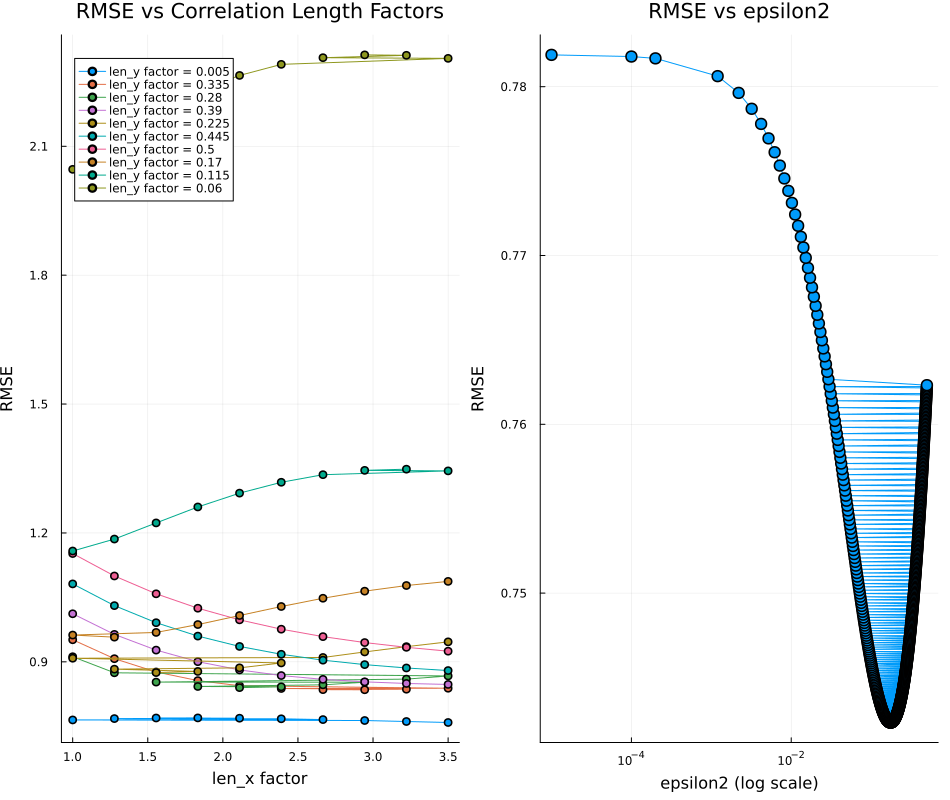

In [12]:
# 9. Visualize results
# Plot RMSE vs correlation length factors
p1 = plot(title="RMSE vs Correlation Length Factors")
for (i, y_factor) in enumerate(unique(len_results.len_y_factor))
    subset = filter(row -> row.len_y_factor == y_factor, len_results)
    plot!(p1, subset.len_x_factor, subset.rmse, 
          label="len_y factor = $(y_factor)", 
          marker=:circle, markersize=4)
end
xlabel!(p1, "len_x factor")
ylabel!(p1, "RMSE")

# Plot RMSE vs epsilon2 (log scale)
p2 = plot(eps2_results.epsilon2, eps2_results.rmse, 
          title="RMSE vs epsilon2", 
          xlabel="epsilon2 (log scale)", 
          ylabel="RMSE", 
          xscale=:log10,
          marker=:circle, markersize=6,
          legend=false)

plot(p1, p2, layout=(1,2), size=(950, 800))